In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 📊 Chargement des données
print("📊 Chargement des données...")
file_path = "C:/Users/Massi/Desktop/MSPR BLOC 03/les_jointeurs/datasets/jointeur_elections_population/Dataset_Finale_MSPR_2025.csv"
data = pd.read_csv(file_path, sep=';')
print(f"Dataset complet: {data.shape[0]} lignes")

📊 Chargement des données...
Dataset complet: 69060 lignes


In [29]:

# 🗺️ Filtrage sur la région Bretagne
bretagne_depts = ['22', '29', '35', '56']
data['code_dept'] = data['commune_id'].astype(str).str[:2]
data_region = data[data['code_dept'].isin(bretagne_depts)].copy()

print(f"📍 Région sélectionnée : Bretagne ({', '.join(bretagne_depts)})")
print(f"✅ Nombre de communes : {data_region.shape[0]}")

# 🎯 Vérification des classes
print("\nClasses d'orientation politique :")
print(data_region['orientation_politique'].value_counts().sort_index())

# 🔧 Nettoyage des données
data_region = data_region.dropna(subset=['orientation_politique'])

📍 Région sélectionnée : Bretagne (22, 29, 35, 56)
✅ Nombre de communes : 2412

Classes d'orientation politique :
orientation_politique
0.0     176
2.0    1733
3.0     121
4.0     382
Name: count, dtype: int64


In [30]:

# 📋 Sélection des variables (features)
features_selected = [
    'nb_inscrits',
    'nb_abstentions',
    'pct_population_jeune',
    'pct_population_sans_activite',
    'pct_population_etrangere',
    'taux_chomage_pct',
    'nb_population_active',
    'Population_Totale',
    'nb_crimes'
]
X = data_region[features_selected].copy()
y = data_region['orientation_politique'].copy()

# 📦 Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [31]:

# 📏 Standardisation (CRUCIALE pour la régression logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔢 Entraînement Régression Logistique avec class_weight='balanced'
logistic_model = LogisticRegression(
    class_weight='balanced',  # Pour gérer le déséquilibre des classes
    max_iter=1000,           # Augmenter les itérations pour la convergence
    solver='liblinear',      # Bon solveur pour les petits datasets
    random_state=42,
    C=1.0                    # Paramètre de régularisation
)
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [32]:

# 🎯 Prédictions et évaluation
y_pred = logistic_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🏆 Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))


🏆 Accuracy : 0.7060 (70.60%)

📊 Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.35      0.51      0.41        35
         2.0       0.81      0.86      0.83       347
         3.0       0.27      0.12      0.17        24
         4.0       0.42      0.27      0.33        77

    accuracy                           0.71       483
   macro avg       0.46      0.44      0.44       483
weighted avg       0.69      0.71      0.69       483




📈 Calcul des courbes d'apprentissage...


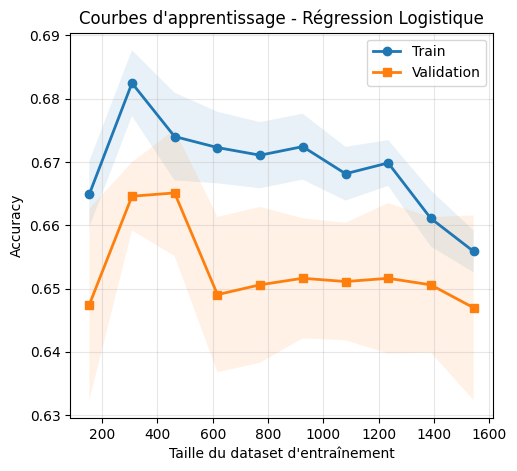

In [22]:
# 📈 COURBES D'APPRENTISSAGE
print("\n📈 Calcul des courbes d'apprentissage...")
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42),
    X_train_scaled, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, label='Train', linewidth=2, marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation', linewidth=2, marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Taille du dataset d\'entraînement')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbes d\'apprentissage - Régression Logistique')
plt.grid(True, alpha=0.3)

📊 Calcul de la courbe de validation...


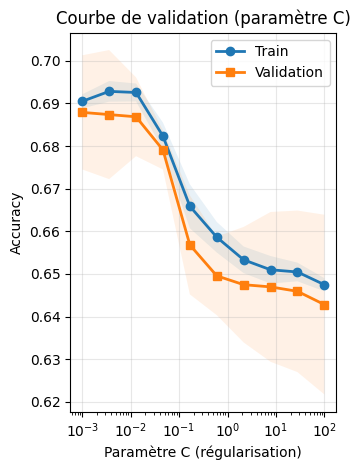

In [23]:

# 📊 COURBE DE VALIDATION (hyperparamètre C - régularisation)
print("📊 Calcul de la courbe de validation...")
C_range = np.logspace(-3, 2, 10)  # De 0.001 à 100
train_scores_val, val_scores_val = validation_curve(
    LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42),
    X_train_scaled, y_train,
    param_name='C',
    param_range=C_range,
    cv=5,
    n_jobs=-1
)

train_mean_val = np.mean(train_scores_val, axis=1)
train_std_val = np.std(train_scores_val, axis=1)
val_mean_val = np.mean(val_scores_val, axis=1)
val_std_val = np.std(val_scores_val, axis=1)

plt.subplot(1, 2, 2)
plt.semilogx(C_range, train_mean_val, label='Train', linewidth=2, marker='o')
plt.fill_between(C_range, train_mean_val - train_std_val, 
                 train_mean_val + train_std_val, alpha=0.1)
plt.semilogx(C_range, val_mean_val, label='Validation', linewidth=2, marker='s')
plt.fill_between(C_range, val_mean_val - val_std_val, 
                 val_mean_val + val_std_val, alpha=0.1)
plt.xlabel('Paramètre C (régularisation)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbe de validation (paramètre C)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

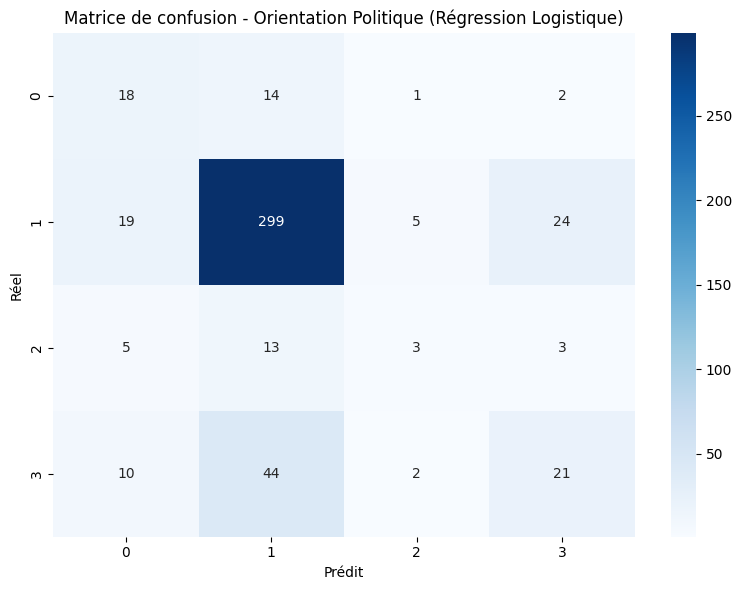

In [24]:

# 🔲 Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - Orientation Politique (Régression Logistique)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


🔍 Coefficients de la régression logistique :
nb_population_active           :  -0.8095 (|0.8095|)
nb_crimes                      :   0.6387 (|0.6387|)
nb_inscrits                    :  -0.3294 (|0.3294|)
Population_Totale              :  -0.2859 (|0.2859|)
nb_abstentions                 :  -0.2720 (|0.2720|)
taux_chomage_pct               :   0.1023 (|0.1023|)
pct_population_sans_activite   :  -0.0231 (|0.0231|)
pct_population_jeune           :  -0.0166 (|0.0166|)
pct_population_etrangere       :  -0.0107 (|0.0107|)


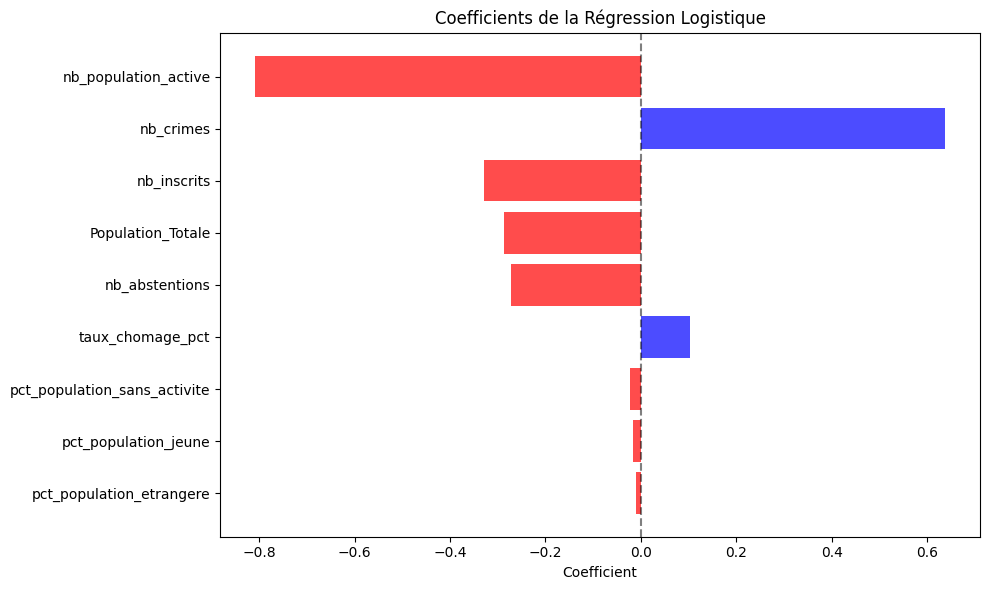

In [25]:

# 🔍 Coefficients de la régression logistique
coefficients = pd.DataFrame({
    'feature': features_selected,
    'coefficient': logistic_model.coef_[0] if len(logistic_model.classes_) == 2 else logistic_model.coef_.mean(axis=0),
    'abs_coefficient': np.abs(logistic_model.coef_[0] if len(logistic_model.classes_) == 2 else logistic_model.coef_.mean(axis=0))
}).sort_values(by='abs_coefficient', ascending=False)

print("\n🔍 Coefficients de la régression logistique :")
for i, row in coefficients.iterrows():
    print(f"{row['feature']:<30} : {row['coefficient']:>8.4f} (|{row['abs_coefficient']:.4f}|)")

plt.figure(figsize=(10, 6))
# Trier par valeur absolue pour l'affichage
coefficients_sorted = coefficients.sort_values(by='abs_coefficient', ascending=True)
colors = ['red' if x < 0 else 'blue' for x in coefficients_sorted['coefficient']]
plt.barh(range(len(coefficients_sorted)), coefficients_sorted['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(coefficients_sorted)), coefficients_sorted['feature'])
plt.xlabel('Coefficient')
plt.title('Coefficients de la Régression Logistique')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


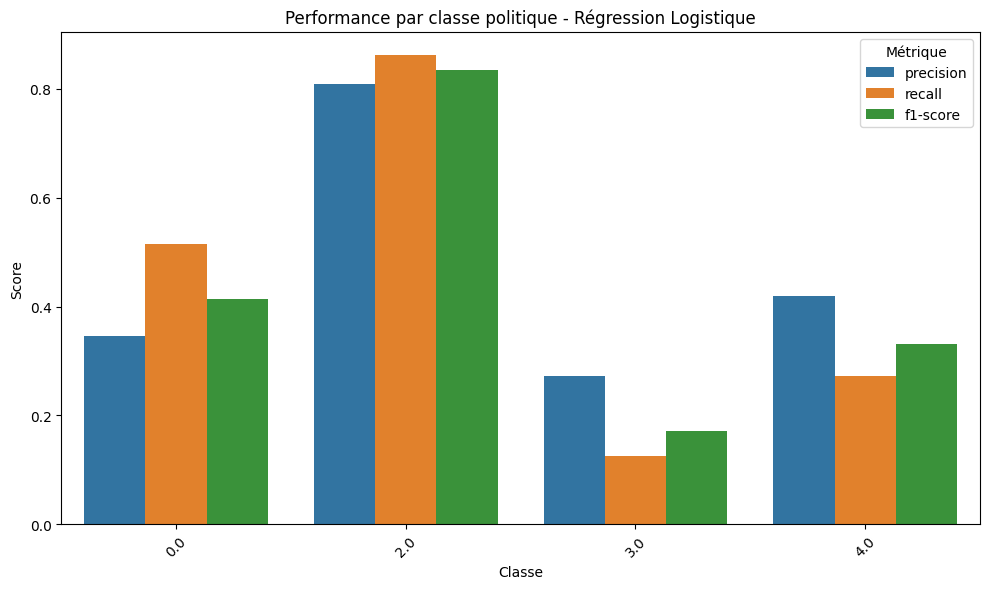

In [26]:

# 📊 Performance par classe
plt.figure(figsize=(10, 6))
report_dict = classification_report(y_test, y_pred, output_dict=True)
classes = [k for k in report_dict.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
metrics = ['precision', 'recall', 'f1-score']

performance_data = []
for classe in classes:
    for metric in metrics:
        performance_data.append({
            'Classe': classe,
            'Métrique': metric,
            'Score': report_dict[classe][metric]
        })

performance_df = pd.DataFrame(performance_data)
sns.barplot(data=performance_df, x='Classe', y='Score', hue='Métrique')
plt.title('Performance par classe politique - Régression Logistique')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:

# 🔮 Fonction de prédiction personnalisée
def predire_orientation(nb_inscrits, nb_abstentions, pct_population_jeune,
                        pct_population_sans_activite, pct_population_etrangere, taux_chomage_pct,
                        nb_population_active, population_totale, nb_crimes):
    new_data = np.array([[nb_inscrits, nb_abstentions, pct_population_jeune,
                          pct_population_sans_activite, pct_population_etrangere, taux_chomage_pct,
                          nb_population_active, population_totale, nb_crimes]])
    new_data_scaled = scaler.transform(new_data)
    prediction = logistic_model.predict(new_data_scaled)[0]
    proba = logistic_model.predict_proba(new_data_scaled)[0]
    
    print(f"🔮 Prédiction : {prediction}")
    print("📊 Probabilités par classe :")
    for i, classe in enumerate(logistic_model.classes_):
        print(f"   {classe} : {proba[i]:.4f} ({proba[i]*100:.2f}%)")
    
    return prediction, proba


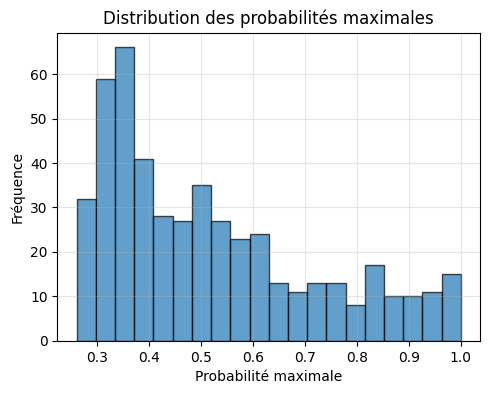

In [13]:

# 📊 Analyse des probabilités prédites
y_proba = logistic_model.predict_proba(X_test_scaled)
plt.figure(figsize=(12, 4))

# Distribution des probabilités max
plt.subplot(1, 2, 1)
max_probas = np.max(y_proba, axis=1)
plt.hist(max_probas, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Probabilité maximale')
plt.ylabel('Fréquence')
plt.title('Distribution des probabilités maximales')
plt.grid(True, alpha=0.3)

In [14]:

# Calibration plot (pour les classes binaires)
if len(logistic_model.classes_) == 2:
    plt.subplot(1, 2, 2)
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        (y_test == logistic_model.classes_[1]).astype(int), 
        y_proba[:, 1], 
        n_bins=10
    )
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Régression Logistique")
    plt.plot([0, 1], [0, 1], "k:", label="Parfaitement calibré")
    plt.xlabel('Probabilité moyenne prédite')
    plt.ylabel('Fraction de positifs')
    plt.title('Courbe de calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [15]:

# 📈 Comparaison des hyperparamètres C
print("\n📈 Analyse de l'impact du paramètre C :")
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
for C in C_values:
    temp_model = LogisticRegression(C=C, class_weight='balanced', max_iter=1000, 
                                   solver='liblinear', random_state=42)
    temp_model.fit(X_train_scaled, y_train)
    temp_pred = temp_model.predict(X_test_scaled)
    temp_acc = accuracy_score(y_test, temp_pred)
    print(f"C = {C:>6.2f} : Accuracy = {temp_acc:.4f} ({temp_acc*100:.2f}%)")

# 📝 Résumé
print("\n🎉 RÉSUMÉ FINAL - RÉGRESSION LOGISTIQUE :")
print(f"📍 Région analysée : Bretagne ({', '.join(bretagne_depts)})")
print(f"📊 Communes utilisées : {len(data_region)}")
print(f"🎯 Accuracy obtenue : {accuracy*100:.2f}%")
print(f"🔢 Nombre de features : {len(features_selected)}")
print(f"📈 Courbes générées : Apprentissage + Validation (paramètre C)")
print(f"⚖️ Class weight : balanced (pour gérer le déséquilibre)")
print(f"🔧 Solver utilisé : liblinear")
print(f"🔍 Feature la plus importante : {coefficients.iloc[0]['feature']} (coeff: {coefficients.iloc[0]['coefficient']:.4f})")



📈 Analyse de l'impact du paramètre C :
C =   0.01 : Accuracy = 0.7164 (71.64%)
C =   0.10 : Accuracy = 0.7039 (70.39%)
C =   1.00 : Accuracy = 0.7060 (70.60%)
C =  10.00 : Accuracy = 0.7019 (70.19%)
C = 100.00 : Accuracy = 0.6749 (67.49%)

🎉 RÉSUMÉ FINAL - RÉGRESSION LOGISTIQUE :
📍 Région analysée : Bretagne (22, 29, 35, 56)
📊 Communes utilisées : 2412
🎯 Accuracy obtenue : 70.60%
🔢 Nombre de features : 9
📈 Courbes générées : Apprentissage + Validation (paramètre C)
⚖️ Class weight : balanced (pour gérer le déséquilibre)
🔧 Solver utilisé : liblinear
🔍 Feature la plus importante : nb_population_active (coeff: -0.8095)
